# AnyoneAI - Sprint Project 04
> Multimodal Product Classification

You've been learning a lot about Deep Learning Algorithms, now we you're gonna be asked to put it all together. 


In [ ]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

In [ ]:
# Check if the O.S is Mx Mac
import platform
IN_MAC = platform.system() == "Darwin"
IN_MAC

In [ ]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

In [ ]:
if IN_COLAB:
    # Put here the full path to the folder having your Sprint project code
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/assignment"
    %cd $ROOT_DIR

## Install dependencies (Only for Colab)

In [ ]:
if IN_COLAB:
    # This will make sure you have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt
    # We can access to GPUs in Colab, so install GPU version of tensorflow
    !pip install tensorflow-gpu==2.10.0

In [ ]:
if IN_MAC:
    # To access the GPU in Mx Mac, we need to install the Metal Plugin
    !pip install tensorflow-macos==2.5.0
    !pip install tensorflow-metal==0.1.2

## 1. Introduction

This is a multi-class classification task: we aim to predict the correct category of a product from BestBuy.com based on its textual and image data. The raw dataset consists of detailed product information stored in JSON files. Our goal is to classify products into one of the predefined categories using both textual and visual features.

The dataset contains two raw JSON files that you can use to understand the data:
- `products.json`: Contains information about the products such as name, description, price, etc.
- `categories.json`: Contains hierarchical information about the product categories.

In this project, we'll provide you with a preprocessed dataset and a zip file containing the images. Place the images in the `data/images` folder in the same directory as the notebook.

- Use the file `processed_products_with_images.csv` and place it in the `data` folder.
- [Download](https://drive.google.com/file/d/14s2aDNTEWse86cWyLhvVIKmob6EbQrm_/view?usp=sharing) and unzip the file `images.zip` and place the images in the `data/images` folder.

The task is divided into several steps:
1. **Exploratory Data Analysis (EDA)** on the product dataset.
2. **Preprocessing** the dataset to prepare it for model training.
3. **Generating embeddings** from both product images and textual descriptions.
4. **Training and evaluating machine learning models** using these embeddings to predict the product category.

The project will focus on leveraging both text and image data to improve the classification accuracy.

In [1]:
### IMPORTS ###
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from src.utils import ImageDownloader
from src.vision_embeddings_tf import get_embeddings_df
from src.nlp_models import HuggingFaceEmbeddings
from src.nlp_models import GPT
from src.utils import preprocess_data, train_test_split_and_feature_extraction
import os

from src.classifiers_classic_ml import train_and_evaluate_model as train_classic

from src.classifiers_mlp import MultimodalDataset
from sklearn.preprocessing import LabelEncoder
from src.classifiers_mlp import train_mlp

2025-07-08 20:09:55.763332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-08 20:09:55.907773: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 20:09:55.946022: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 20:09:56.756384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

### 1.1 Getting the data

To access the data for this project, you only need the file `processed_products_with_images.csv`, and the images from [this link](https://drive.google.com/file/d/14s2aDNTEWse86cWyLhvVIKmob6EbQrm_/view?usp=sharing). You can place the file in the `data` directory and the images in the `data/images` directory. The images were downloaded using the `ImageDownloader` class provided in the `utils.py` file in a 224 x 224 pixel format, but if you want to download the images yourself in a higher resolution, you can use the `ImageDownloader` class to do so. using the code below:

```python
# Load the data:
CSV_PATH = 'data/processed_products.csv'
df = pd.read_csv(CSV_PATH)

# Download the images and add the image paths to the dataframe:
DIR='data/images/'
SHAPE=(224, 224)
OVERWRITE=False
OUTPUT_CSV='data/processed_products_with_images.csv'

# Instantiate the ImageDownloader class
image_downloader = ImageDownloader(image_dir=DIR, image_size=SHAPE, overwrite=OVERWRITE)

# Download images and get the updated DataFrame
updated_df = image_downloader.download_images(df)

# Save the updated DataFrame
updated_df.to_csv(CSV_PATH, index=False)
```

#### 1.1. Simple EDA

- Read the data and display the first few rows.
- Display some images from the dataset.

In [2]:
# See the data
df = pd.read_csv('data/processed_products_with_images.csv')
df.head()

,sku,name,description,image,type,price,shipping,manufacturer,class_id,sub_class1_id,num_classes,image_path
0,43900,Duracell - AAA Batteries (4-Pack),Compatible with select electronic devices; AAA...,http://img.bbystatic.com/BestBuy_US/images/pro...,HardGood,5.49,5.49,Duracell,pcmcat312300050015,pcmcat248700050021,2,data/images/43900.jpg
1,48530,Duracell - AA 1.5V CopperTop Batteries (4-Pack),Long-lasting energy; DURALOCK Power Preserve t...,http://img.bbystatic.com/BestBuy_US/images/pro...,HardGood,5.49,5.49,Duracell,pcmcat312300050015,pcmcat248700050021,2,data/images/48530.jpg
2,127687,Duracell - AA Batteries (8-Pack),Compatible with select electronic devices; AA ...,http://img.bbystatic.com/BestBuy_US/images/pro...,HardGood,7.49,5.49,Duracell,pcmcat312300050015,pcmcat248700050021,2,data/images/127687.jpg
3,150115,Energizer - MAX Batteries AA (4-Pack),4-pack AA alkaline batteries; battery tester i...,http://img.bbystatic.com/BestBuy_US/images/pro...,HardGood,4.99,5.49,Energizer,pcmcat312300050015,pcmcat248700050021,2,data/images/150115.jpg
4,185230,Duracell - C Batteries (4-Pack),Compatible with select electronic devices; C s...,http://img.bbystatic.com/BestBuy_US/images/pro...,HardGood,8.99,5.49,Duracell,pcmcat312300050015,pcmcat248700050021,2,data/images/185230.jpg


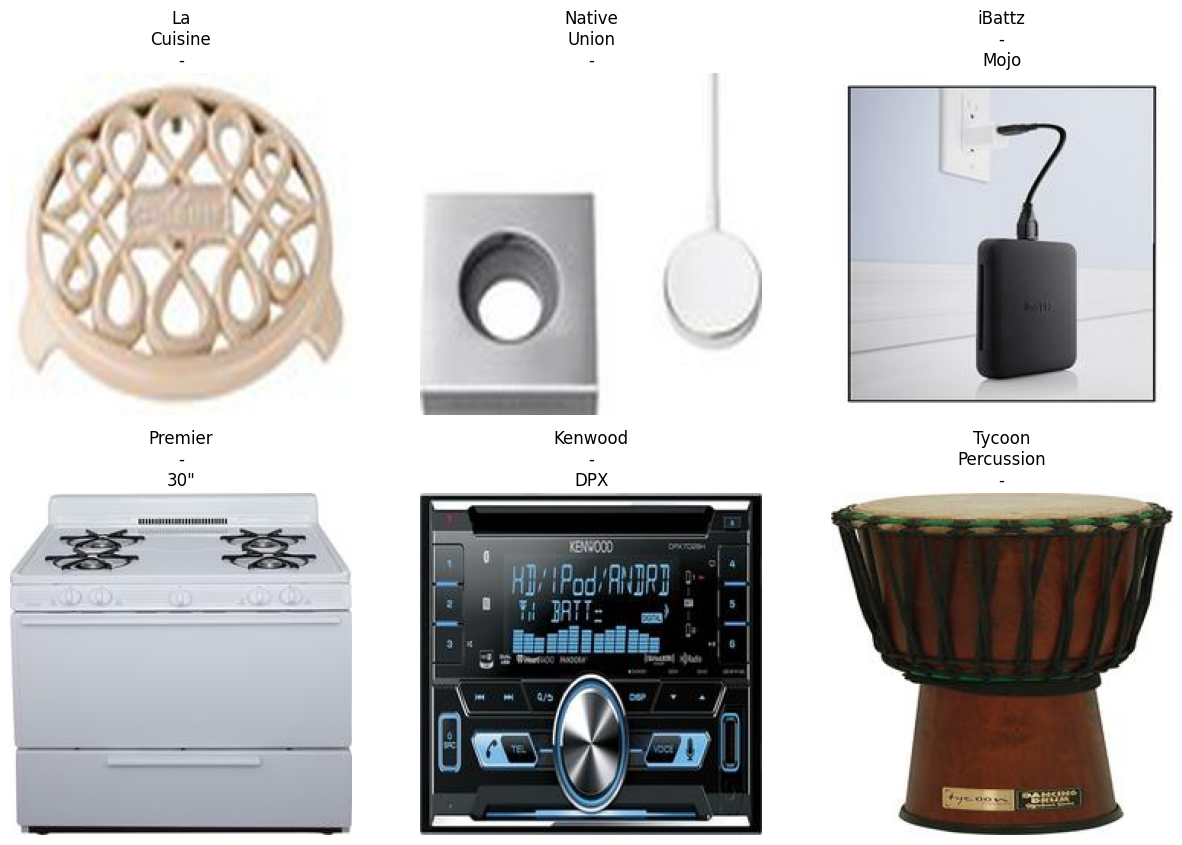

In [3]:
# Display 6 random images from the dataset
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
for i in range(2):
    for j in range(3):
        # Get a random index
        idx = df.sample().index[0]
        # Read the image
        img = mpimg.imread(df.loc[idx, 'image_path'])
        # Display the image
        ax[i, j].imshow(img)
        # Set the title
        ax[i, j].set_title('\n'.join(df.loc[idx, 'name'].split()[:3]))
        ax[i, j].axis('off')


## 2.Embedding Generation

We have two types of data: textual and image data. Unfortunately, these data types are high dimensional and extremely different from each other. To make them compatible for a machine learning model, and homogeneous, we will generate embeddings for both the textual and image data.

As you remember from the lectures on embeddings, they are a way to represent high-dimensional data in a lower-dimensional space, some sort of feature extraction. In this project, we will use pre-trained models to generate these embeddings.

The first step is to generate embeddings for both the textual and image data. We will use pre-trained models to generate these embeddings.

#### 2.1. Image Embeddings

We will use a pre-trained model to generate image embeddings. The model will take an image as input and output a vector of fixed size that represents the image. We will use the `get_embeddings_df` function to extract embeddings from images using a backbone model using `Tensorflow` and `Transformers`.

use `get_embeddings_df` function to extract embeddings from images using a backbone model.

```python
get_embeddings_df(
    batch_size=32,
    path='data/images',
    output_dir='Embeddings',
    backbone='vit_base'
)

```

List of possible backbones you can implement:

* resnet50
* resnet101
* densenet121
* densenet169
* inception_v3
* convnextv2_tiny
* convnextv2_base
* convnextv2_large
* swin_tiny
* swin_small
* swin_base
* vit_base
* vit_large
* clip_base
* clip_large

**You should at least implement [tensorflow ConvNextV2](https://huggingface.co/docs/transformers/en/model_doc/convnextv2#transformers.TFConvNextV2Model) from Hugging Face and `ResNet50` from [tensorflow.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications).**


* Output: The function will create a file `Embeddings_{model_name}.csv` containing the image name and the embeddings for each image in the dataset in the directory `Embeddings`. The embeddings are represented as n columns, where n is the size of the embedding vector.

In [4]:
batch_size = 32
path = 'data/images'
dataset = 'Embeddings_imageNet'
backbone = 'convnextv2_tiny'
out_dir = 'Embeddings'

get_embeddings_df(batch_size=batch_size, path=path, dataset_name=dataset, backbone=backbone, directory=out_dir)

2025-07-08 20:10:55.259870: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-07-08 20:10:55.259904: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-07-08 20:10:55.259933: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (debian): /proc/driver/nvidia/version does not exist
2025-07-08 20:10:55.260269: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFConvNextV2M

1/1 [==============================] - 21s 21s/step
Batch 10/1553 done
1/1 [==============================] - 18s 18s/step
Batch 20/1553 done
1/1 [==============================] - 15s 15s/step
Batch 30/1553 done
1/1 [==============================] - 15s 15s/step
Batch 40/1553 done
1/1 [==============================] - 16s 16s/step
Batch 50/1553 done
1/1 [==============================] - 17s 17s/step
Batch 60/1553 done
1/1 [==============================] - 15s 15s/step
Batch 70/1553 done
1/1 [==============================] - 22s 22s/step
Batch 80/1553 done
1/1 [==============================] - 23s 23s/step
Batch 90/1553 done
1/1 [==============================] - 23s 23s/step
Batch 100/1553 done
1/1 [==============================] - 24s 24s/step
Batch 110/1553 done
1/1 [==============================] - 20s 20s/step
Batch 120/1553 done
1/1 [==============================] - 15s 15s/step
Batch 130/1553 done
1/1 [==============================] - 16s 16s/step
Batch 140/1553 done
1

KeyboardInterrupt: 

### 2.2. Text Embeddings

For text embeddings, we will use a pre-trained model to generate embeddings for the product descriptions. The model will take a text input and output a vector of fixed size that represents the text. We will use the `HuggingFaceEmbeddings` class to extract embeddings from text using a pre-trained transformer model from the Hugging Face library.

* Optional: You can use the `GPT` class to generate embeddings for the product descriptions using a model avaialble in the OpenAI API.




2.2.1 HuggingFaceEmbeddings

The `HuggingFaceEmbeddings` class is used to generate embeddings for text data using pre-trained transformer models from the Hugging Face library. The class takes the following parameters:

- `model_name`: The name of the pre-trained transformer model to use.
- `device`: The device to use for processing the data ('cpu', 'cuda', 'mps').
- `path`: The path to the CSV file containing the text data.

The class has the method `get_embedding_df` that generates embeddings for a given text column in a CSV file and saves the embeddings to a new CSV file. The method takes the following parameters:

- `column`: The name of the text column in the CSV file.
- `directory`: The directory to save the embeddings file.
- `file`: The name of the embeddings file to save.

```python
# Usage example for BERT:
device = 'mps'
model = HuggingFaceEmbeddings(model_name='bert-base-uncased', device=device)

model.path = 'data/processed_products_with_images.csv'
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings_bert.csv'

model.get_embedding_df(column, directory, file)
```

* Output: The function will create a file with the defined name `file` (e.g., `text_embeddings_bert.csv`) containing the product metadata and the embeddings for each text description in the dataset. The dataset will be stored in the directory `directory` (e.g., `Embeddings/`). The embeddings are represented as a list in a **single column** with the name `embeddings`. **Don't convert the text embeddings into multiple columns in the dataframe, leave it as a list, since the conversion will be done in the next step.**

**The class should work at least for `sentence-transformers/all-MiniLM-L6-v2`, but optionally, you can implement it for other models as well.**

In [ ]:
# Usage example for all-MiniLM-L6-v2:
device = 'mps' # Set to 'cuda' if you have a GPU, 'cpu' otherwise
model = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', device=device)

model.path = 'data/processed_products_with_images.csv' # This is the output of the previous step
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings_minilm.csv'

model.get_embedding_df(column, directory, file)

2.2.2 GPT **Optional**

The `GPT` class is used to generate embeddings for text data using the OpenAI API. 


* **Backbone:** Select an embedding model from the list of possible [embedding models](https://platform.openai.com/docs/models/embeddings)

Ussage example:

```python
# Choose your model from the list of models:
model = GPT(embedding_model='text-embedding-3-small')

model.path = 'data/processed_products_with_images.csv'
column = 'description'
directory = 'Embeddings/'
file = 'text_embeddings.csv'

model.get_embedding_df(column, directory, file)
```


In [ ]:
# Optional: Use OpenAI's API to get the embeddings


### 2.3 Merge Embeddings

Once you have the embeddings, you need to merge them into a single dataset. You can use the `preprocess_data` function to merge the embeddings and preprocess the dataset for training.

The function needs the following parameters:

- `text_data`: The path to the CSV file containing the text embeddings.
- `image_data`: The path to the CSV file containing the image embeddings.
- `text_id`: The name of the column containing the text IDs.
- `image_id`: The name of the column containing the image IDs.
- `embeddings_col`: The name of the column containing the embeddings.

```python
preprocess_data(text_data, image_data, text_id="image_id", image_id="ImageName", embeddings_col = 'embeddings')
```

* Output: The function will create a dataframe with the embeddings from both the text and image data. The dataframe will contain the text and image IDs, the product category, as well as the metadata for the product, and `n` + `m` new extra columns with the embeddings, where `n` is the size of the text embeddings and `m` is the size of the image embeddings. The new embedding columns will be named `text_0`, `text_1`, ..., `text_n`, `image_0`, `image_1`, ..., `image_m`.

In [ ]:
# Merge the embeddings
PATH = 'Embeddings/'
text_path = 'text_embeddings_minilm.csv'
images_path = 'Embeddings_convnextv2_tiny.csv'

# Read unimodal data
text = pd.read_csv(os.path.join(PATH, text_path))

images = pd.read_csv(os.path.join(PATH, images_path))

# Merge and preprocess the datasets
df = preprocess_data(text, images, "image_path", "ImageName")

df.to_csv(os.path.join(PATH, 'embeddings_minilm.csv'), index=False)

## 3. Machine Learning Models Training

We'll be using 2 approaches to train the model:

1. A classical machine learning model using the embeddings generated from the text and image data.
2. A deep learning model using the embeddings generated from the text and image data to train a neural network.

In order to do a fair comparison between the two approaches, we will use the same train/test split for both models. We will use 70% of the data for training and 30% for testing.

### 3.1 Dataset Preparation

The first step is to prepare the dataset for training. We will use the `train_test_split` function to split function from the `sklearn` library to split the dataset into training and testing sets.

Then we will define the image embedding columns and the text embedding columns to be used in the model.

You can use those columns to train 3 models per approach:
* A model using only the image embeddings.
* A model using only the text embeddings.
* A model using both the image and text embeddings, or multimodal model.

In [ ]:
# Read the data:
PATH = 'Embeddings/'
df = pd.read_csv(os.path.join(PATH, 'embeddings_minilm.csv'))

# Split the data into train and test sets and extract the features
train_df, test_df, text_columns, image_columns, label_columns = train_test_split_and_feature_extraction(df)

### 3.2. Classical ML model Training

After generating the embeddings, we will train a machine learning model to predict the product category based on the embeddings. We will use the `train_and_evaluate_model` (`train_classic` in this code) function to train a classic machine learning model using the embeddings.

**You should at least implement the following models: `RandomForest`, and `LogisticRegression`.**

In [ ]:
### Labels
y_train = train_df[label_columns].values
y_test = test_df[label_columns].values

#### 3.2.1. Train and Evaluate Text Model

In [ ]:
# Combine text columns to form the feature set
X_train = train_df[text_columns].values
X_test = test_df[text_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 3.2.2. Train and Evaluate Image Model

In [ ]:
# Combine image columns to form the feature set
X_train = train_df[image_columns].values
X_test = test_df[image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

#### 3.2.3. Train and Evaluate Combined Model

In [ ]:
# Combine text and image columns to form the feature set
X_train = train_df[text_columns + image_columns].values
X_test = test_df[text_columns + image_columns].values

# Train and evaluate models
trained_models = train_classic(X_train, X_test, y_train, y_test)

### 3.3 Multi-layer Perceptron

*Now it's time to train our first Neural Network model. For simplicity, we are going to try using an MLP model.*

*A Multi-layer Perceptron (MLP) is a simple neural network consisting of multiple layers of nodes connected by weighted edges. The input and output layers have one node per feature, and one node per target class respectively, while the intermediate layers have an arbitrary number of nodes.*

In this case you'll train 3 models:
* A model using only the image embeddings.
* A model using only the text embeddings.
* A model using both the image and text embeddings, or multimodal model.

In order to do that, you can use the `train_mlp` function to train a neural network model using the embeddings. Is important that you create a correct setup in `src/classifiers_mlp.py` to train the model.

Once you train each model, it will generate a classification report and a confusion matrix to evaluate the model's performance. It will also generate a folder `results` with the files `results/multimodal_results.csv`, `results/image_results.csv`, or `results/text_results.csv` containing the results of your model on the test set. Those files are necessary for the final evaluation, so don't remove, rename or change them.

**You must achieve at least 85% accuracy and 80% F1-score for the multimodal model, an accuracy of at least 85% and an F1-score of at least 80% for the text model, and an accuracy of at least 75% and an F1-score of at least 70% for the image model.**

#### 3.3.1 Perpare the dataset

In [ ]:
# Initialize LabelEncoder and fit it only on the training data
label_encoder = LabelEncoder()
label_encoder.fit(train_df[label_columns])

#### 3.3.2. Train and Evaluate the image model

In [ ]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=None, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=None, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)

text_input_size = None
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

In [ ]:
# Train the model
print("Training Image Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

#### 3.3.3. Train and Evaluate the text model

In [ ]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=text_columns, image_cols=None, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=text_columns, image_cols=None, label_col=label_columns, encoder=label_encoder)

text_input_size = len(text_columns)
image_input_size = None
output_size = label_encoder.classes_.shape[0]

In [ ]:
# Train the model
print("Training Text Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

#### 3.3.4. Train and Evaluate the fusion model

In [ ]:
# Create the datasets and ensure the encoder is passed to both train and test sets
train_dataset = MultimodalDataset(train_df, text_cols=text_columns, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)
test_dataset = MultimodalDataset(test_df, text_cols=text_columns, image_cols=image_columns, label_col=label_columns, encoder=label_encoder)

text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = label_encoder.classes_.shape[0]

In [ ]:
# Train the model
print("Training Early Fusion Model:")
train_mlp(train_dataset, test_dataset,
            text_input_size=text_input_size, 
            image_input_size=image_input_size, 
            output_size=output_size, 
            num_epochs=50,
            report=True, 
            lr=0.001, 
            set_weights=True, 
            adam=True, 
            p=0.2,  
            seed=42, 
            patience=10)

Take into account that the model trained will be evaluated in multiple classes. It's important to use the right loss function and metrics for this task. 

Check the perfermance of the model in each class. Is the model overfitting? Underfitting? What can you do to improve the model?

Aditionally, the fusion model is performing better than the individual models? Why?

## 7. Optional. Make your own model

The models we've trained before are just a limited set over the universe of stuff you can use. 

You still have a lot of things to experiment with to increase accuracy, some ideas are:

1. Use other pre-trained models for text and image embeddings.
2. Use closed-source models like OpenAI's models from the API.
2. Try adding data augmentation or any other regularization algorithms.
4. Check [KerasTuner](https://keras.io/api/keras_tuner/) documentation about how to efficiently test a lot of different architectures and parameters.
5. Is there a trade-off between the different models in terms of performance and computational cost? How would you decide which model to use in a production environment?